In [1]:
import numpy as np
import pandas as pd
import soundfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from IPython.display import Audio

In [2]:
# loading the clean and noisy data
X_clean=np.load('data/clean_train.npy')
X_noisy=np.load('data/noisy_train.npy')

In [ ]:
# X_clean=X_clean[:10000]
# X_noisy=X_noisy[:10000]

# X_clean=np.array(X_clean)
# X_noisy=np.array(X_noisy)

In [3]:
X_clean.shape,X_noisy.shape

((17084, 1024, 32, 1), (17084, 1024, 32, 1))

In [4]:
def wplot(arr,title="Waveform",xlab='Time (seconds)',ylab='Amplitude'):
    librosa.display.waveshow(arr, sr=16000)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

def spec_plot(spec,title="Spectogram",sr=16000):
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()


In [5]:
#will plot a sample spectogram
def sample_spec():
    l=X_clean.shape[0]
    idx=random.randint(0,l)
    print(f"the index plotting {idx}")
    arr=np.squeeze(X_clean[idx],axis= -1)
    brr=np.squeeze(X_noisy[idx],axis= -1)
    print("clean stft")
    spec_plot(arr)
    print(" noisy stft")
    spec_plot(brr)


In [6]:
#will plot a sample wave plot
def sample_wplot():
    l=X_clean.shape[0]
    idx=random.randint(0,l)
    print(f"the index plotting {idx}")
    arr=np.squeeze(X_clean[idx],axis= -1)
    brr=np.squeeze(X_noisy[idx],axis= -1)
    
    clean_inv = librosa.griffinlim(arr)
    wplot(clean_inv)
    noisy_inv=librosa.griffinlim(brr)
    wplot(noisy_inv)

the index plotting 4959


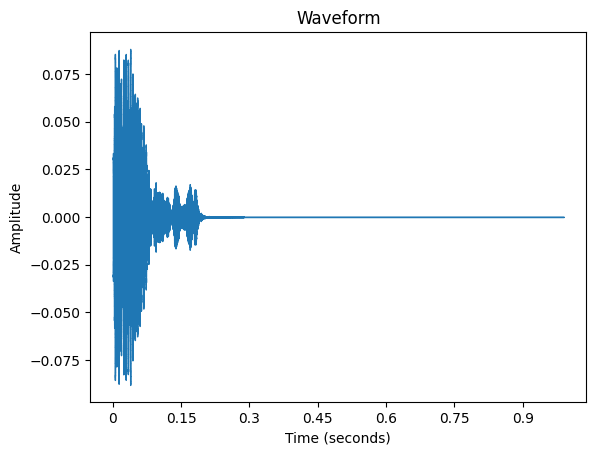

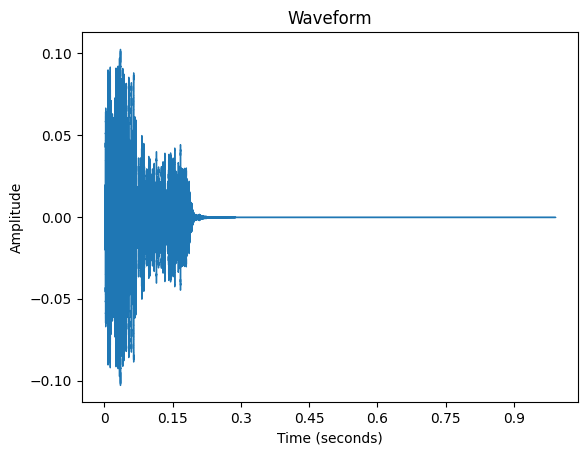

In [7]:
sample_wplot()

the index plotting 10735
clean stft


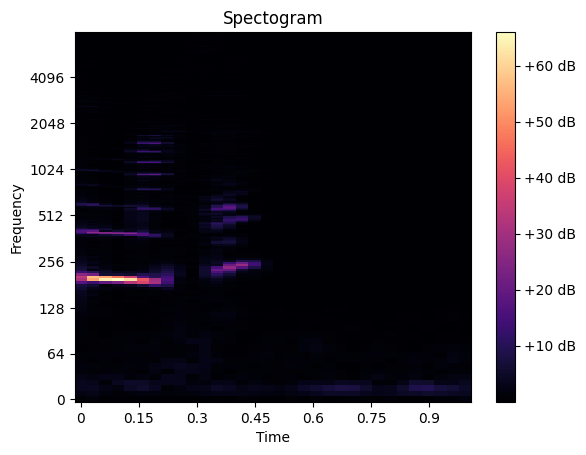

 noisy stft


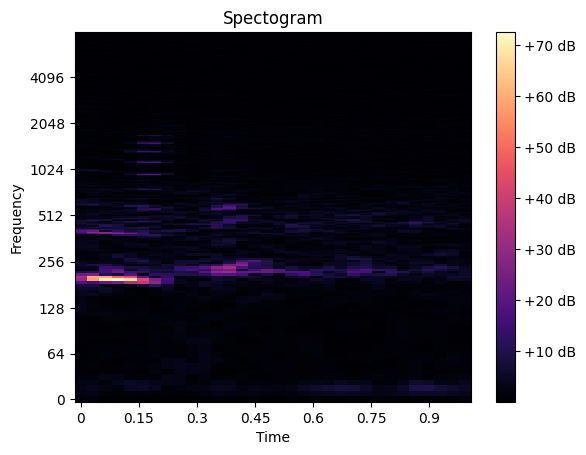

In [8]:
sample_spec()

In [9]:
def get_audio(typ='clean',sample_rate=16000):
    l=X_clean.shape[0]
    idx=random.randint(0,l)
    
    if typ=='clean':
        arr=np.squeeze(X_clean[idx],axis= -1)
    elif typ=='noisy':
        arr=np.squeeze(X_noisy[idx],axis= -1)
    else:
        print("Invalid type!")
        return 
        
    clean_inv = librosa.griffinlim(arr)
    Audio(clean_inv,rate=sample_rate)

In [14]:
l=X_clean.shape[0]
idx=random.randint(0,l)
    
arr=np.squeeze(X_clean[idx],axis= -1)
brr=np.squeeze(X_noisy[idx],axis= -1)
clean_inv = librosa.griffinlim(arr)
noisy_inv =librosa.griffinlim(brr)
Audio(clean_inv,rate=16000)

In [15]:
Audio(noisy_inv,rate=16000)

In [16]:
class ZeroOneNorm():
    '''
    Normalizes arrays relative to a target array.
    '''
    def __init__(self):
        self.data_to_fit = []
        self.data_to_transform = []
    # Fit to a specific array:
    def fit(self, data_to_fit):
        self.fitting_constant = np.max(np.abs(data_to_fit))
    # Normalize according to fit:
    def normalize(self, data_to_transform):
        normalized_data = data_to_transform / self.fitting_constant
        return normalized_data
    # De-normalize:
    def denormalize(self, data_to_transform):
        denormalized_data = data_to_transform * self.fitting_constant
        return denormalized_data

In [13]:
prep = ZeroOneNorm()
prep.fit(X_noisy)
# Normalize all data:
X_clean_n = prep.normalize(X_clean)
X_noisy_n = prep.normalize(X_noisy)

In [14]:
l=X_clean.shape[0]
idx=random.randint(0,l)
    
arr=np.squeeze(X_clean[idx],axis= -1)
brr=np.squeeze(X_clean_n[idx],axis= -1)

In [17]:
#sample audio
audio_inv = librosa.griffinlim(arr)
Audio(audio_inv,rate=16000)  

In [18]:
#normalized audio
naudio_inv =librosa.griffinlim(brr)
Audio(naudio_inv,rate=16000)

In [19]:
spec_shape=(X_clean_n.shape[1],X_clean_n.shape[2],X_clean_n.shape[3])

In [20]:
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split

In [21]:
# Convolutional Autoencoder:


encoder_input = keras.Input(shape=(spec_shape[0], spec_shape[1], spec_shape[2]), name = 'encoder_in')
#x = layers.Conv2D(64, (5, 5), activation='relu', padding='same', name='conv_1')(encoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_1')(encoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_2')(x)
encoder_output = layers.MaxPooling2D((2, 2), padding='same', name = 'maxpool')(x)

decoder_input = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'decoder_in')(encoder_output)
x = layers.UpSampling2D((2, 2), name = 'upsample')(decoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'deconv_2')(x)
 x= layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',  name = 'deconv_1')(x)
decoder_output = layers.Conv2D(64, (5, 5), activation='relu', padding='same', name='conv_1')(x)

# Autoencoder:
autoencoder = keras.Model(encoder_input, decoder_output, name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_in (InputLayer)              │ (None, 1024, 32, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 1024, 32, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 1024, 32, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool (MaxPooling2D)               │ (None, 512, 16, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_in (Conv2D)                  │ (None, 512, 16, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample (UpSampling2D)              │ (None, 1024, 32, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ deconv_2 (Conv2D)                    │ (None, 1024, 32, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ deconv_1 (Conv2D)                    │ (None, 1024, 32, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_noisy_n[:10000], X_clean_n[:10000], test_size = 0.40)

In [23]:
x_train.shape

(9600, 1024, 32, 1)

In [24]:
# Training callbacks:
my_callbacks = [keras.callbacks.EarlyStopping(patience=5), 
                keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=4),
               ]
# Optimizer, learning rate:
opt = keras.optimizers.Adam(learning_rate=0.001)
# Compile Autoencoder w/ optimizer and binary crossentropy loss:
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

In [25]:
# history
history = autoencoder.fit(x_train, y_train,
                epochs=50,
                shuffle=True,
                verbose = 1,
                callbacks = my_callbacks
                )

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - loss: 0.1300 - learning_rate: 0.0010
Epoch 2/50


C:\Users\ECE\PycharmProjects\deeps\.venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - loss: 0.0057 - learning_rate: 1.0000e-04
Epoch 12/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - loss: 0.0057 - learning_rate:

In [26]:
def spec_plot(spec,title='spec plot'):
    spectrogram = spec.reshape((1024, 32))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref = np.max))
    plt.show()

In [27]:
def plot_training(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
  
    plt.plot(epochs, train_loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    

In [28]:
plot_training(history)

KeyError: 'val_loss'

In [29]:
arr=np.squeeze(x_train[0],axis= -1)
brr=np.squeeze(y_train[0],axis= -1)
clean_inv = librosa.griffinlim(brr)
noisy_inv =librosa.griffinlim(arr)
Audio(noisy_inv,rate=16000)

In [30]:
Audio(clean_inv,rate=16000)

In [31]:
y_pred=autoencoder.predict(x_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 347ms/step


In [103]:
l=x_test.shape[0]
idx=random.randint(0,l)
print(f"the index is {idx}")
arr=np.squeeze(x_test[idx],axis= -1)
brr=np.squeeze(y_test[idx],axis= -1)
crr=np.squeeze(y_pred[idx],axis= -1)

the index is 3216


In [104]:
#clean audio
clean_inv = librosa.griffinlim(brr)
Audio(clean_inv,rate=16000)

In [105]:
#noisy audio
noisy_inv = librosa.griffinlim(arr)
Audio(noisy_inv,rate=16000)

In [106]:
#pred audio
pred_inv = librosa.griffinlim(crr)
Audio(pred_inv,rate=16000)

In [36]:
autoencoder.evaluate(x_test,y_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 172ms/step - loss: 0.0058


0.005758313927799463

In [38]:
autoencoder.save("denoiser_autoencoder.keras")

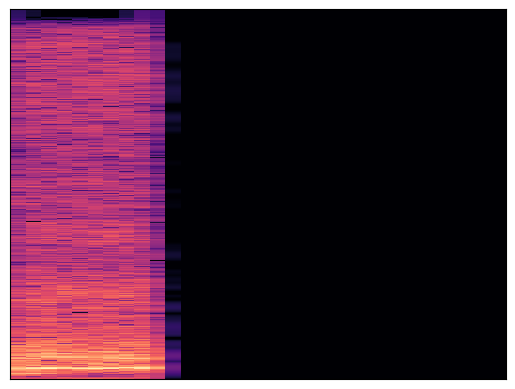

In [100]:
spec_plot(arr)

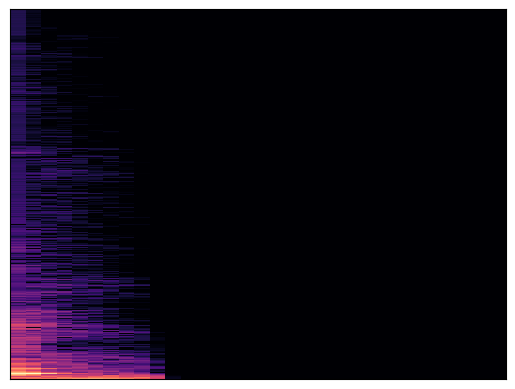

In [101]:
spec_plot(brr)

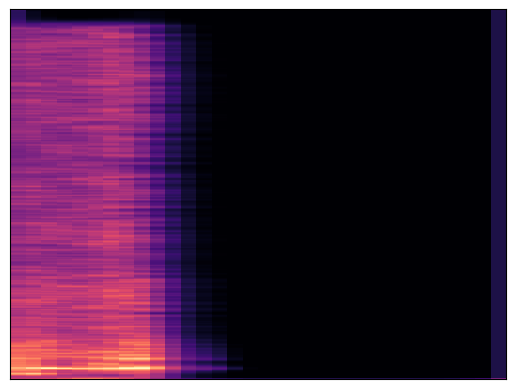

In [102]:
spec_plot(crr)

In [91]:
def resize_audio(arr,r=16000):
    l=len(arr)
    i=0
    cnt=0
    br=[]
    brr=[]
    
    while i<l:
        br.append(arr[i])
        i+=1
        cnt+=1
        if cnt==r:
            brr.append(br)
            br=[]
            cnt=0

    if len(br)!=0:
        br.extend([0]*(r-len(br)))
        brr.append(br)
    
    return brr

def convert(arr,sample_rate=16000,duration_s=1):
    brr=resize_audio(arr)
    brr=np.array(brr)
    
    audio = []
    
    # Get duration in samples:
    duration = int(sample_rate * duration_s)

    for data in brr:
        S=np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        audio.append(S)
        
    audio = np.array(audio)
    audio = np.expand_dims(audio, -1)
    
    y_pred=autoencoder.predict(audio)

    res=[]
    for yp in y_pred:
        crr=np.squeeze(yp,axis= -1)
        aud=librosa.griffinlim(crr)
        res.extend(aud)

    return y_pred

In [48]:
from datasets import load_dataset
from IPython.display import Audio
ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")

In [71]:
data=ds['train'].select(range(100))

In [72]:
clean=[]
noisy=[]

for el in data:
    clean.append(np.array(el['clean']['array']))
    noisy.append(np.array(el['noisy']['array']))

In [92]:
l=len(clean)
idx=random.randint(0,l)
print(f"the index is {idx}")

the index is 80


In [93]:
Audio(clean[idx],rate=16000)

In [94]:
Audio(noisy[idx],rate=16000)

In [95]:
pred=convert(noisy[idx])
Audio(pred,rate=16000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
